In [2]:
# can we classify based on features
%load_ext autoreload
%autoreload 2

In [44]:
from fastai import *
from fastai.vision import *
from tqdm import tqdm
assert torch.cuda.is_available()
import pandas as pd
import numpy as np
from torchvision import transforms

In [12]:
HOME_PATH = "/local_scratch/wamsterd/git/lidc-representation/"
os.chdir(HOME_PATH)

In [181]:
df_all = pd.read_csv("data/labels.csv")
# df_all["split"] = df_all.name.apply(lambda x: x.split("/")[0])
print(df_all.split.value_counts())
df_all["name"] = df_all["out_dir"]
df_all.head()

train    2154
test      476
Name: split, dtype: int64


,nodule_idx,nodule_number,patient_id,scan_id,patient_number,calcification_median,calcification_mean,calcification_min,calcification_max,calcification_var,...,texture_max,texture_var,n_annotations_count,label,id,split,out_name,out_dir,orig_path,name
0,101,1.0,LIDC-IDRI-0001,12,1,6.0,6.0,6,6,0.0,...,5,0.250000,4,1,101,train,000101.png,train/000101.png,/local_scratch/wamsterd/data/lidc/allnods2D/00...,train/000101.png
1,201,1.0,LIDC-IDRI-0002,13,2,6.0,6.0,6,6,0.0,...,2,0.500000,2,0,201,train,000201.png,train/000201.png,/local_scratch/wamsterd/data/lidc/allnods2D/00...,train/000201.png
2,301,1.0,LIDC-IDRI-0003,14,3,6.0,6.0,6,6,NaN,...,1,NaN,1,0,301,train,000301.png,train/000301.png,/local_scratch/wamsterd/data/lidc/allnods2D/00...,train/000301.png
3,302,2.0,LIDC-IDRI-0003,14,3,6.0,6.0,6,6,0.0,...,5,0.666667,4,1,302,train,000302.png,train/000302.png,/local_scratch/wamsterd/data/lidc/allnods2D/00...,train/000302.png
4,303,3.0,LIDC-IDRI-0003,14,3,6.0,6.0,6,6,0.0,...,5,0.250000,4,0,303,train,000303.png,train/000303.png,/local_scratch/wamsterd/data/lidc/allnods2D/00...,train/000303.png


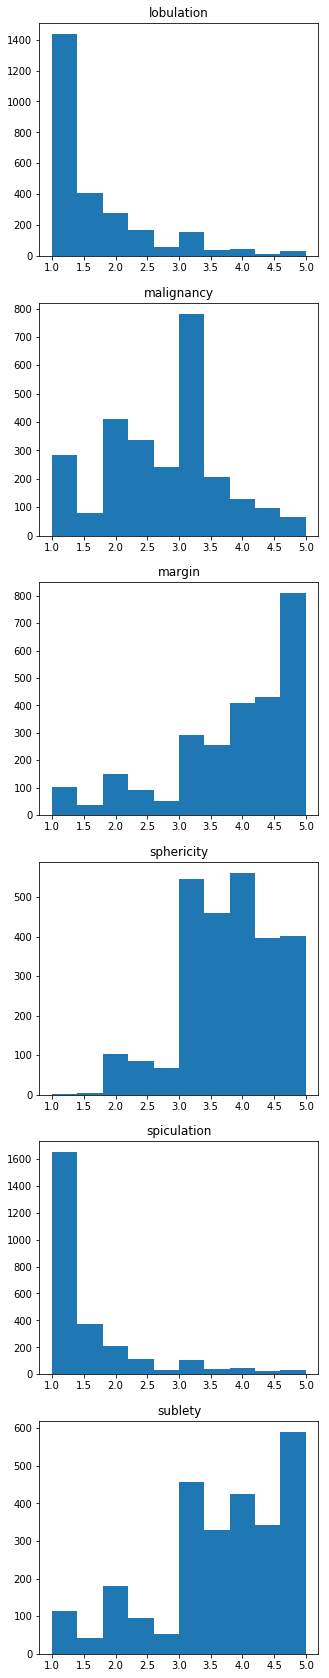

In [109]:
measure_vars = [x.split("_")[0] for x in df_all.columns if x.endswith("_mean")]
measure_vars = ["lobulation", "malignancy", "margin", "sphericity", "spiculation", "sublety"]

fig, axes = plt.subplots(len(measure_vars), 1, figsize = (5, 30))
# fig.set_figheight(20)
for i, var in enumerate(measure_vars):
    axes[i].hist(df[var+"_mean"])
    axes[i].set_title(var)

In [182]:
dfs = {}
borderline_ptc = .2

for var in measure_vars:
    df = df_all
    df["label_cont"] = df[var + "_mean"]
    df["name"] = df["out_dir"]
    label_median = df.label_cont.median()
    borderline_range = df.label_cont.quantile(.5 + np.array([-1, 1]) * borderline_ptc / 2)
    df = df[~df.label_cont.isin(borderline_range)]
    df["label"] = (df.label_cont > label_median).astype(int)
    print(var)
    print(df.label.value_counts())
    dfs[var] = df


/local_scratch/wamsterd/anaconda3/envs/fastai180/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


lobulation
1    1074
0     182
Name: label, dtype: int64
malignancy
0    1125
1     638
Name: label, dtype: int64
margin
1    1154
0     982
Name: label, dtype: int64
sphericity
0    1169
1     800
Name: label, dtype: int64
spiculation
1    1165
Name: label, dtype: int64
sublety
0    1100
1     932
Name: label, dtype: int64


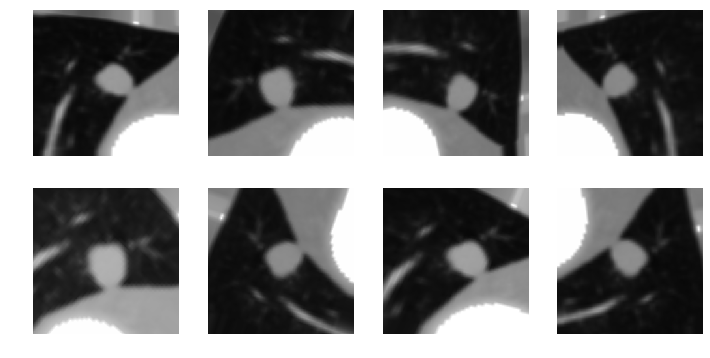

In [184]:
SZ = 224
BS = 256
# tfms = get_transforms(padding_mode = "border")
tfms = get_transforms(max_rotate = 90)
test_tfms = []
df_margin = dfs["margin"]
def get_ex(): return open_image("data/"+df_margin.loc[5, "name"])

def plots_f(rows, cols, width, height, **kwargs):
    [get_ex().apply_tfms(tfms[0], **kwargs).show(ax=ax) for i,ax in enumerate(plt.subplots(
        rows,cols,figsize=(width,height))[1].flatten())]
plots_f(2, 4, 12, 6, size=SZ, padding_mode = "border")

1335
333


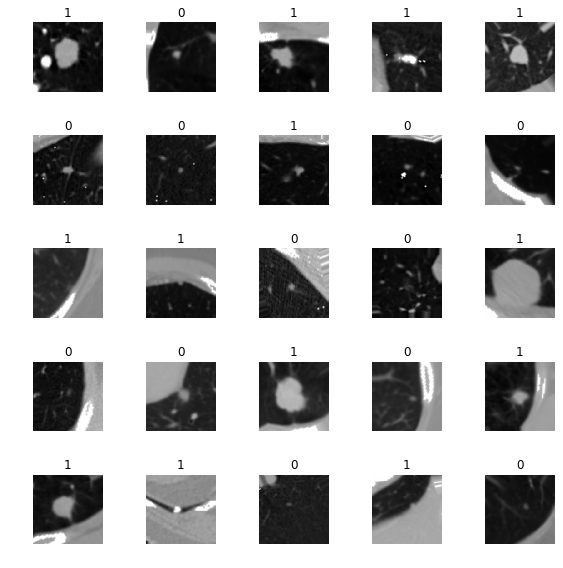

In [185]:
datas = {}
for var, df in dfs.items():
    data = ImageDataBunch.from_df(df = df[df.split == "train"], 
                              label_col = "label", fn_col = "name",
                              path = "data", ds_tfms=tfms, size=SZ, valid_pct=.2,
                              padding_mode = "border", bs = BS)
    datas[var] = data

# data_test = ImageDataBunch.from_df(df = df[df.split == "test"], 
#                               label_col = "label", fn_col = "name",
#                               path = "data", ds_tfms=test_tfms, size=SZ, valid_pct=.01,
#                               padding_mode = "zeros", bs = 128)

print(len(data.train_ds))
print(len(data.valid_ds))
# print(len(data.test_ds))
data.show_batch(rows = 5, figsize = (8,8))

In [194]:
cb = [ShowGraph]
# cb.append(OneCycleScheduler(learn, lr_max=0.01))
learners = {}
for var, data in datas.items():
    learn = create_cnn(data, models.resnet18, metrics = accuracy, callback_fns=cb)
    learners[var] = learn

In [188]:
for var, learn in tqdm(learners.items()):
    learn.lr_find()
# learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


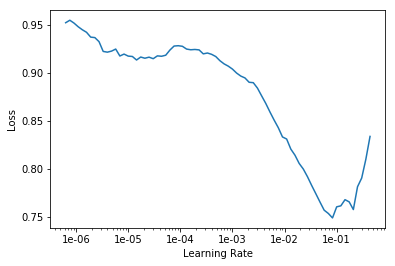

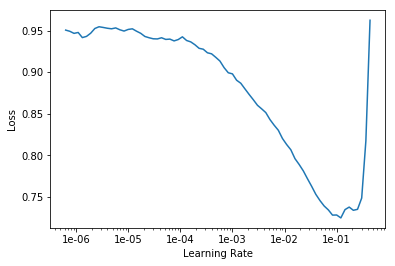

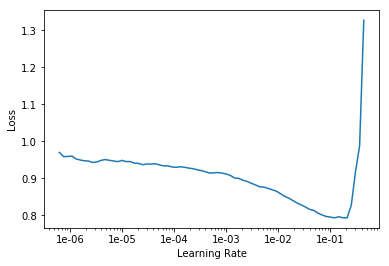

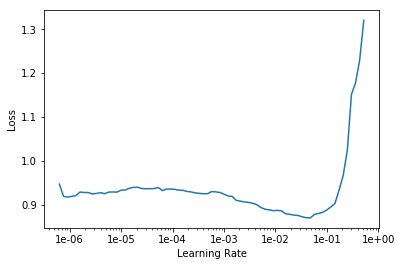

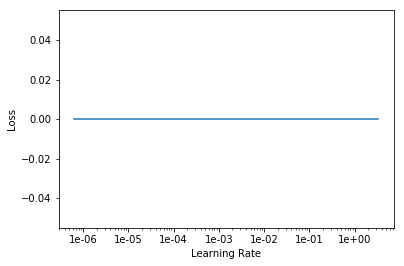

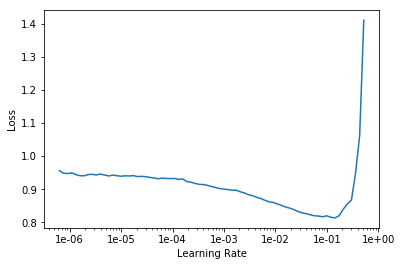

In [192]:
for i, var in enumerate(measure_vars):
    learners[var].recorder.plot()


100%|██████████| 6/6 [02:44<00:00, 27.37s/it]


Total time: 00:30
epoch  train_loss  valid_loss  accuracy
1      1.113214    0.725868    0.588589  (00:06)
2      0.927566    1.013489    0.567568  (00:06)
3      0.812108    0.772338    0.588589  (00:05)
4      0.743928    0.696000    0.606607  (00:05)
5      0.696771    0.544584    0.735736  (00:05)



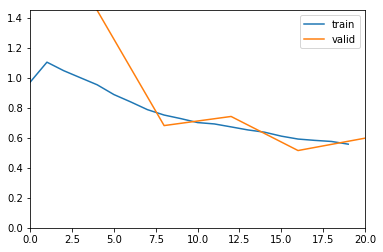

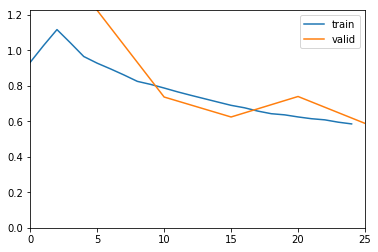

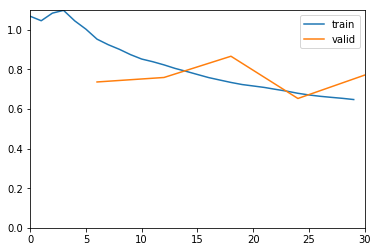

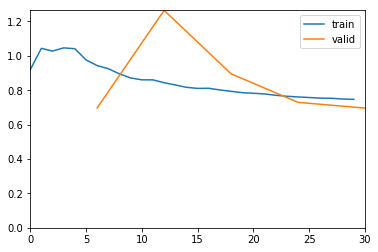

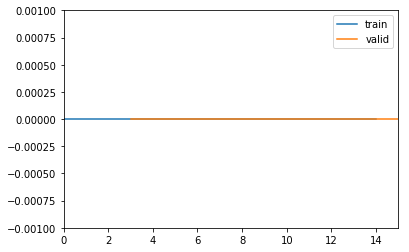

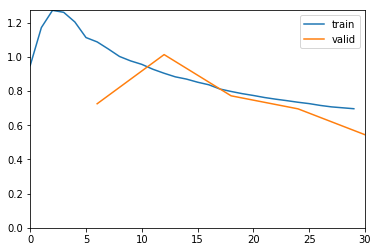

In [195]:
for var, learn in tqdm(learners.items()):
    print(var)
    learn.fit(5, lr = 1e-02)

In [211]:
metric_df = {}
for var, learn in learners.items():
    accs = learn.recorder.metrics
    metric_df[var] = np.array(accs).squeeze()
pd.DataFrame(metric_df)

,lobulation,malignancy,margin,sphericity,spiculation,sublety
0,0.282178,0.626298,0.524217,0.613497,1.0,0.588589
1,0.826733,0.619377,0.538462,0.389571,1.0,0.567568
2,0.826733,0.657439,0.561254,0.475460,1.0,0.588589
3,0.826733,0.702422,0.652422,0.549080,1.0,0.606607
4,0.826733,0.726644,0.649573,0.607362,1.0,0.735736


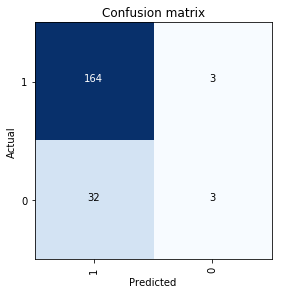

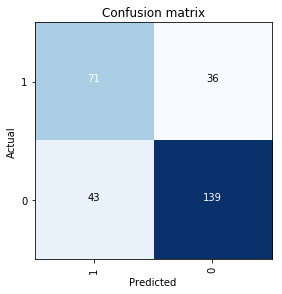

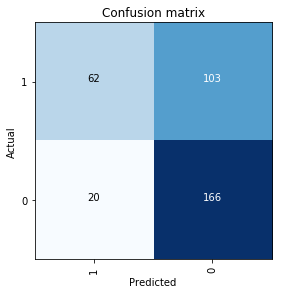

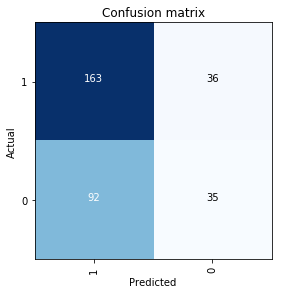

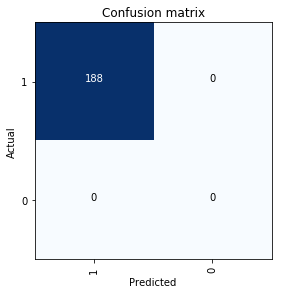

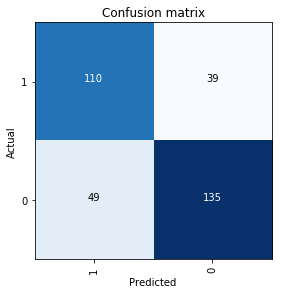

In [212]:
interps = {}
for var, learn in learners.items():
    preds,y,losses = learn.get_preds(with_loss=True)
    interp = ClassificationInterpretation(data, preds, y, losses)
    interps[var] = interp
    interp.plot_confusion_matrix()

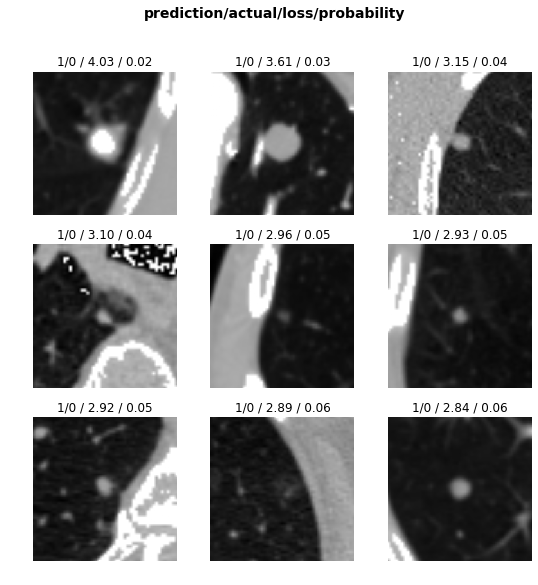

In [135]:
interp.plot_top_losses(9, figsize = (9,9))